In [18]:
import os
import re
import pandas as pd
import numpy as np
import glob
import nltk
import unicodedata
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, precision_score, recall_score
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import classification_report
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from sklearn.svm import SVC
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [4]:
# load data
file_path = r"../datasets/"
train_file = r"train.csv"
test_file = r"test.csv"
subm_file = r"sample_submission.csv"

train = pd.read_csv(file_path+train_file)
test = pd.read_csv(file_path+test_file)

print(train.shape)
train.head()

(7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


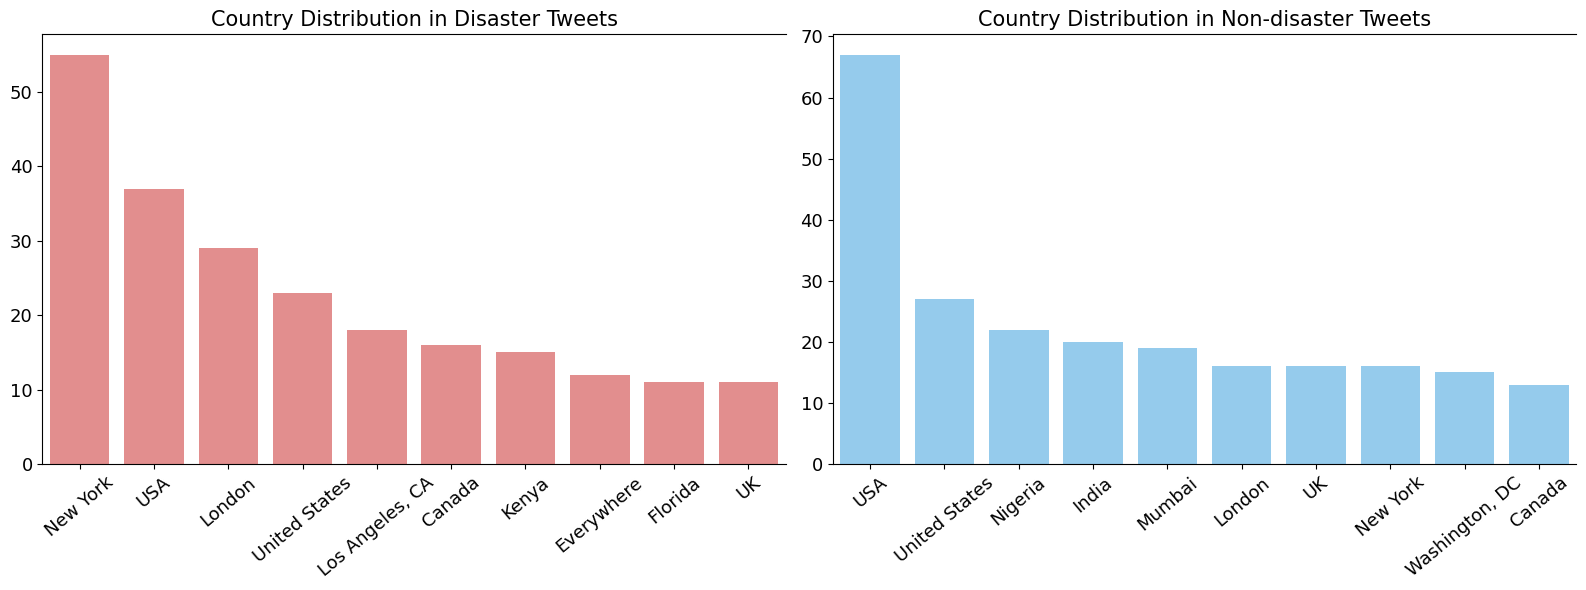

In [5]:
fig, axes = plt.subplots(ncols=2, figsize=(16,6), dpi=100,tight_layout=True)
sns.barplot(y=train[train['target'] == 0]['location'].value_counts()[:10], x=train[train['target'] == 0]['location'].value_counts()[0:10].index, ax=axes[0], color='lightcoral')
sns.barplot(y=train[train['target'] == 1]['location'].value_counts()[:10], x=train[train['target'] == 1]['location'].value_counts()[0:10].index, ax=axes[1], color='lightskyblue')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13, rotation=40)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title('Country Distribution in Disaster Tweets', fontsize=15)
axes[1].set_title('Country Distribution in Non-disaster Tweets', fontsize=15)

plt.show()

In [6]:
train.location.value_counts()

location
USA                    104
New York                71
United States           50
London                  45
Canada                  29
                      ... 
Some pum pum             1
Paulton, England         1
SEA Server               1
todaysbigstock.com       1
???????? ?????????.      1
Name: count, Length: 3341, dtype: int64

In [7]:
train.keyword.value_counts()

keyword
fatalities               45
armageddon               42
deluge                   42
harm                     41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: count, Length: 221, dtype: int64

In [8]:
def accurarcy(y_test, y_pred):
    f1 = f1_score(y_test, y_pred, average='macro')
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    
    print(f'F1 Score: {f1 * 100:.2f}%')
    print(f'precision: {precision * 100:.2f}%')
    print(f'recall: {recall * 100:.2f}%')
    
    report = classification_report(y_test, y_pred)
    print("Report:\n", report)

In [9]:
emoji_pattern = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)

In [10]:
def clean_tweet(tweet):
    # Remove URLs
    tweet = re.sub(r'http\S+', '', tweet)
    
    # Remove mentions (@username)
    tweet = re.sub(r'@\w+', '', tweet)
    
    # Remove hashtags (#)
    tweet = re.sub(r'#', '', tweet)
    
    # Remove hashtags preceded by spaces
    tweet = re.sub(r' #', ' ', tweet)
    
    # Remove dashes (-)
    tweet = re.sub(r'-', '', tweet)
    
    # Remove special characters and punctuations (except alphanumeric and spaces)
    tweet = re.sub(r'[^\w\s]', '', tweet)
    
    # Remove non-ASCII characters and emojis
    tweet = ''.join(char for char in tweet if char in string.printable)
    
    # Remove punctuation using Unicode categories
    tweet = ''.join(char for char in tweet if not unicodedata.category(char).startswith('P'))
    
    # Convert to lowercase
    tweet = tweet.lower()
    
    # Remove extra whitespaces
    tweet = ' '.join(tweet.split())
    
    # Remove numbers
    tweet = re.sub(r'\d+', '', tweet)
    
    # Remove single characters (e.g., 'a', 'b', 'c')
    tweet = re.sub(r'\b\w\b', '', tweet)
    
    # Remove multiple spaces
    tweet = re.sub(r'\s+', ' ', tweet)
    
    # Remove the word "nan"
    tweet = re.sub(r'\bnan\b', '', tweet)

    tweet = emoji_pattern.sub(r'', tweet)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tweet = ' '.join(word for word in tweet.split() if word not in stop_words)
    
    return tweet
    
def get_wordnet_pos(word):
    # 将词性标签映射到WordNet词性标签
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag = {'J': wordnet.ADJ, 'N': wordnet.NOUN, 'V': wordnet.VERB, 'R': wordnet.ADV}.get(tag, wordnet.NOUN)
    return tag

def dataset_clean(train,test):
    #Preprocessing
    train['text_clean']=train.text.apply(clean_tweet)
    test['text_clean']=test.text.apply(clean_tweet)
    
    #Lemmatization
    lemma=WordNetLemmatizer()
    train['text_lemma']=train['text_clean'].apply(lambda x: ' '.join(lemma.lemmatize(word, get_wordnet_pos(word)) for word in x.split()))
    test['text_lemma']=test['text_clean'].apply(lambda x: ' '.join(lemma.lemmatize(word, get_wordnet_pos(word)) for word in x.split()))
    
    #tokenization
    train['tokens']=train['text_lemma'].apply(lambda x: word_tokenize(x))
    test['tokens'] = test['text_lemma'].apply(lambda x: word_tokenize(x))
    
    return train, test

In [11]:
train,test = dataset_clean(train,test)
train.head()

,id,keyword,location,text,target,text_clean,text_lemma,tokens
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deeds reason earthquake may allah forgive us,deed reason earthquake may allah forgive u,"[deed, reason, earthquake, may, allah, forgive..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada,forest fire near la ronge sask canada,"[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,residents asked shelter place notified officer...,resident ask shelter place notify officer evac...,"[resident, ask, shelter, place, notify, office..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders cal...,people receive wildfire evacuation order calif...,"[people, receive, wildfire, evacuation, order,..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfires pou...,get sent photo ruby alaska smoke wildfire pour...,"[get, sent, photo, ruby, alaska, smoke, wildfi..."


In [13]:
#split data
#X=train["text_lemma"]
X=train["tokens"]
y=train['target'].values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
val_data, X_val, val_labels, y_val = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

In [14]:
#using TFIDF
X_train_flattened = [" ".join(tokens) for tokens in X_train]
X_val_flattened = [" ".join(tokens) for tokens in X_val]

# Now you can use TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_flattened)
X_val_tfidf = tfidf_vectorizer.transform(X_val_flattened)

### Using Naive Bayes with TFIDF

In [15]:
#using Naive Bayes
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_tfidf, y_train)

y_pred_nb = nb_classifier.predict(X_val_tfidf)
accurarcy(y_val,y_pred_nb)

F1 Score: 80.61%
precision: 82.72%
recall: 80.13%
Report:
               precision    recall  f1-score   support

           0       0.78      0.92      0.85       635
           1       0.87      0.68      0.77       507

    accuracy                           0.81      1142
   macro avg       0.83      0.80      0.81      1142
weighted avg       0.82      0.81      0.81      1142



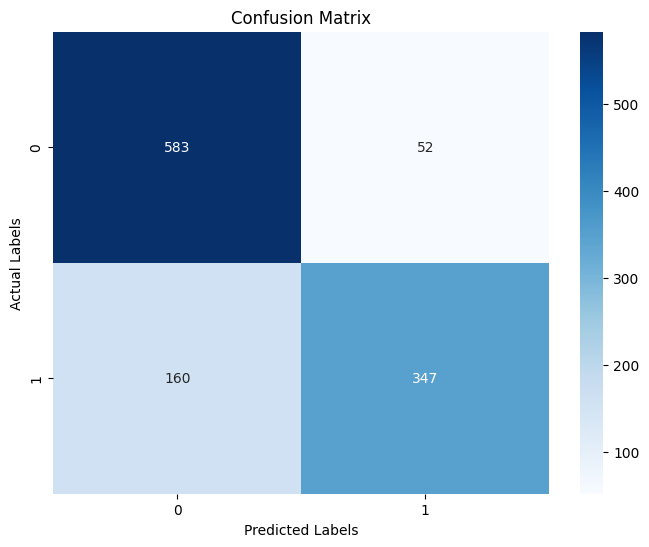

In [19]:
cm = confusion_matrix(y_val, y_pred_nb)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# 添加轴标签
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')

# 添加标题
plt.title('Confusion Matrix')


# 显示图形
# plt.show()
plt.savefig('naive_tfidf.png', dpi=500)

### Using SVM with TFIDF

In [16]:
#using SVM
svm_model=SVC(kernel="linear", probability=True)
svm_model.fit(X_train_tfidf, y_train)

y_pred_svm = svm_model.predict(X_val_tfidf)
accurarcy(y_val,y_pred_svm)

F1 Score: 80.62%
precision: 81.52%
recall: 80.29%
Report:
               precision    recall  f1-score   support

           0       0.80      0.88      0.84       635
           1       0.83      0.72      0.77       507

    accuracy                           0.81      1142
   macro avg       0.82      0.80      0.81      1142
weighted avg       0.81      0.81      0.81      1142



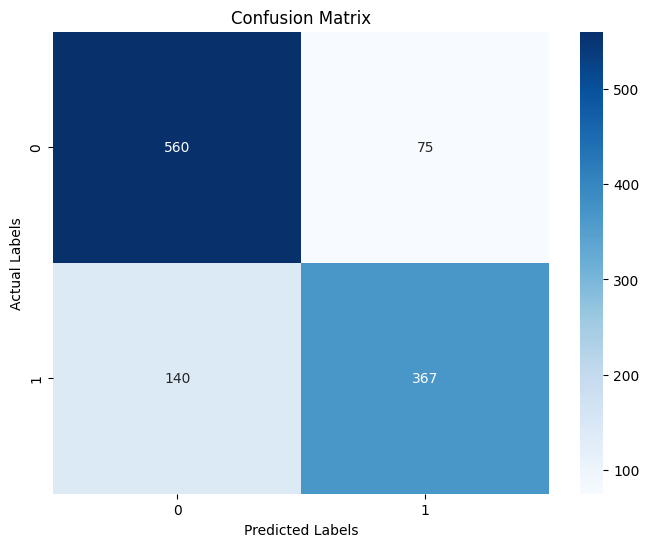

In [20]:
cm = confusion_matrix(y_val, y_pred_svm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# 添加轴标签
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')

# 添加标题
plt.title('Confusion Matrix')


# 显示图形
# plt.show()
plt.savefig('svm_tfidf.png', dpi=500)

### Using MLP with TFIDF

In [21]:
# Define a custom MLP model
device = torch.device('cpu')

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.Sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.Sigmoid(x)
        return x

# Initialize the MLP model
input_dim = X_train_tfidf.shape[1]
hidden_dim = 128  # You can adjust the number of hidden units
output_dim = 1  # For binary classification
model = MLP(input_dim, hidden_dim, output_dim).to(device)

# Define loss and optimizer
#criterion = nn.BCEWithLogitsLoss()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/home/jovyan/miniconda3/envs/nlp_project1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
num_epochs = 5
# Convert CSR matrix to PyTorch tensors
X_train_tfidf_tensor = torch.tensor(X_train_tfidf.toarray(), dtype=torch.float32)
X_val_tfidf_tensor = torch.tensor(X_val_tfidf.toarray(), dtype=torch.float32)

# Convert labels to PyTorch tensors
y_train_tensor = torch.FloatTensor(y_train).view(-1, 1).to(device)
y_val_tensor = torch.FloatTensor(y_val).view(-1, 1).to(device)

for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tfidf_tensor)  # Use TF-IDF vectors directly
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    
# Evaluation
with torch.no_grad():
    outputs = model(X_val_tfidf_tensor)
    predicted = (outputs >= 0.5).float().view(-1, 1)  # Adjust threshold for binary classification
    accuracy = (predicted == y_val_tensor).sum().item() / y_val_tensor.size(0)
    #print(f'Test Accuracy: {accuracy * 100:.2f}%')
    
    predicted_binary = (outputs >= 0.5).float().view(-1, 1)
    y_val_binary = (y_val_tensor >= 0.5).float().view(-1, 1)
    accurarcy(y_val_binary,predicted_binary)

F1 Score: 77.23%
precision: 77.16%
recall: 77.38%
Report:
               precision    recall  f1-score   support

         0.0       0.81      0.78      0.79       635
         1.0       0.73      0.77      0.75       507

    accuracy                           0.77      1142
   macro avg       0.77      0.77      0.77      1142
weighted avg       0.78      0.77      0.77      1142



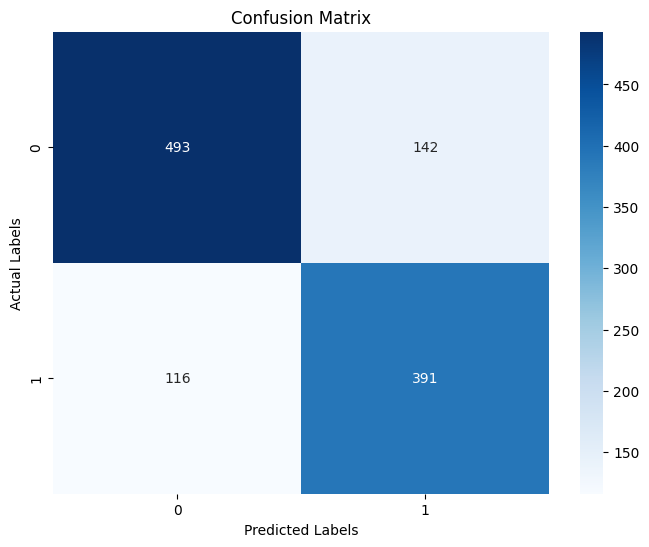

In [24]:
cm = confusion_matrix(y_val_binary, predicted_binary)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# 添加轴标签
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')

# 添加标题
plt.title('Confusion Matrix')


# 显示图形
# plt.show()
plt.savefig('mlp_tfidf.png', dpi=500)